# Cell Capacity
The battery data toolkit uses a simple defintion of the charge and discharge capacity of a battery with nuanced implications.
In short, we integrate the power and current moving out of the battery over time then 
use the maximum change from the start of the cycle to determine the capacity.
We illustrate the subtle parts below.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from battdat.postprocess.integral import StateOfCharge, CapacityPerCycle
from battdat.data import BatteryDataset
from pathlib import Path

## Load Example Data
We have two simple cells that vary only by the where the "cycle" starts.

In [2]:
from_charged = BatteryDataset.from_hdf('../../../tests/files/example-data/single-resistor-constant-charge_from-charged.hdf')

In [3]:
from_discharged = BatteryDataset.from_hdf('../../../tests/files/example-data/single-resistor-constant-charge_from-discharged.hdf')

## Step 1: Intergrate Current and Power
First integrate the current ($I$) and power output ($IV$) of a battery to determine the amount of charge and energy charged into the battery each cycle.

The `StateOfCharge` tool in battery-data-toolkit computes these integrals.

In [4]:
charge = StateOfCharge()

In [5]:
charge.compute_features(from_charged);
charge.compute_features(from_discharged);

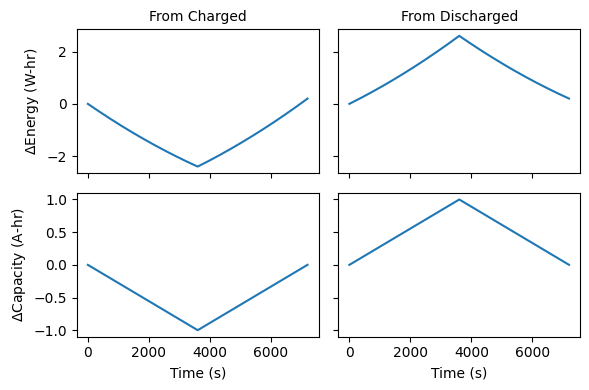

In [6]:
fig, axxs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(6., 4.))

for axs, data, label in zip(axxs.T, [from_charged, from_discharged], ['Charged', 'Discharged']):
    axs[0].set_title(f'From {label}', fontsize=10)
    axs[0].plot(data.raw_data['test_time'], data.raw_data['cycled_energy'])
    axs[1].plot(data.raw_data['test_time'], data.raw_data['cycled_charge'])

axxs[0, 0].set_ylabel('$\Delta$Energy (W-hr)')
axxs[1, 0].set_ylabel('$\Delta$Capacity (A-hr)')

for ax in axxs[-1, :]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()

The energy changes are negative for the battery which starts from fully-charged and positive for a battery which starts from empty.

## Step 2: Assess Whether the Starting Point is Charged
We determine the starting point of the battery as "charged" or "discharged" as whether the maximum change from the start is positive or negative.
It's clear in the image above that the "from charged" battery releases charge in the beginning of the cycle before returning to zero, 
and the "from discharged" doe sthe opposite.

> Note: This definition assumes that a cycle returns a battery to as close to the initial charging state as possible.


## Step 3: Assign Capacities
We set capacities are using the maximum change from starting capacity, and 
the difference between that maximum and the change between the start and end of a cycle.
What each difference represents depends on whether the battery starts by discharging or charging.

In [7]:
capc = CapacityPerCycle()

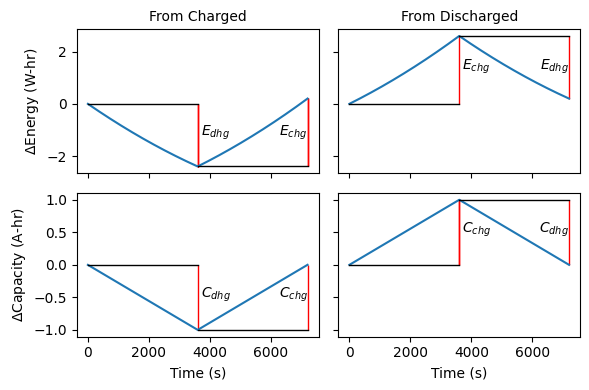

In [8]:
fig, axxs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(6., 4.))

for axs, data, label in zip(axxs.T, [from_charged, from_discharged], ['Charged', 'Discharged']):
    capc.compute_features(data)

    # Start with the changes over time
    axs[0].set_title(f'From {label}', fontsize=10)
    axs[0].plot(data.raw_data['test_time'], data.raw_data['cycled_energy'])
    axs[1].plot(data.raw_data['test_time'], data.raw_data['cycled_charge'])

    # Annotate the capacities/energies
    row = data.cycle_stats.iloc[0]
    axs[0].set_xlim(ax.get_xlim())
    for ax in axs:
        ax.plot([0, 3600], [0, 0], 'k-', lw=1)

    # Plot the energies
    for i, t in enumerate(['energy', 'capacity']):
        first_level = (-row[f'{t}_discharge'] if label == 'Charged' else row[f'{t}_charge'])
        axs[i].arrow(3600, 0, 0, first_level, color='red')
        axs[i].text(3700, first_level / 2., '$' + t[0].upper() + '_{' + ("dhg" if label == "Charged" else "chg") + '}$')
    
        axs[i].plot([3600, 7200], [first_level] * 2, 'k-', lw=1)
        second_level = (-row[f'{t}_discharge'] if label != 'Charged' else row[f'{t}_charge'])
        axs[i].arrow(7200, first_level, 0, second_level, color='red')
        axs[i].text(7200, first_level / 2., '$' + t[0].upper() + '_{' + ("dhg" if label != "Charged" else "chg") + '}$', ha='right')
    

axxs[0, 0].set_ylabel('$\Delta$Energy (W-hr)')
axxs[1, 0].set_ylabel('$\Delta$Capacity (A-hr)')

for ax in axxs[-1, :]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('figures/explain-capacities.png', dpi=320)

The charge and discharge energies (or capacities) for the battery is the same for both cycles, we just have to look a different parts of the curve for each cycle.

## Demonstrate on a Complex Cycling
As an example for how the capacity measurements aren't always meaningful, let's consider the same battery but with a charging cycle which is interrupted with a short discharge

In [9]:
complex_cyc = BatteryDataset.from_hdf('../../../tests/files/example-data/single-resistor-complex-charge_from-discharged.hdf')

Text(0, 0.5, 'Current (A)')

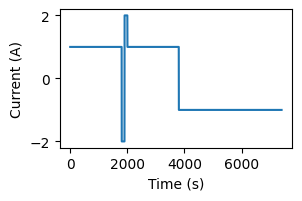

In [10]:
fig, ax = plt.subplots(figsize=(3., 1.8))

ax.plot(complex_cyc.raw_data['test_time'], complex_cyc.raw_data['current'])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')

It is still possible and meaningful to measure the change in charge and the energy added to the battery system.

In [11]:
charge.compute_features(complex_cyc);

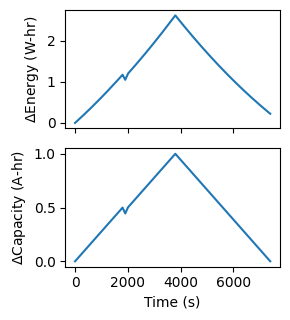

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(3., 3.3))

axs[0].plot(complex_cyc.raw_data['test_time'], complex_cyc.raw_data['cycled_energy'])
axs[1].plot(complex_cyc.raw_data['test_time'], complex_cyc.raw_data['cycled_charge'])

axs[0].set_ylabel('$\Delta$Energy (W-hr)')
axs[1].set_ylabel('$\Delta$Capacity (A-hr)')

axs[1].set_xlabel('Time (s)')

fig.tight_layout()

However, the measurements of capacity get strange

In [13]:
capc.compute_features(complex_cyc)

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge,max_cycled_capacity
0,0,2.62234,1.0,2.398389,0.999444,1.0


In [14]:
from_discharged.cycle_stats

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge,max_cycled_capacity
0,0,2.600084,1.0,2.397584,0.999167,1.0


The discharge part of the cycle is unchanged, so the estimates for the discharge energy and capacity are nearly identical (just numerical differences) between the simple and complex charge.

The charge part of the cycle is different between the two cycles. The integral of current over that time is the same, so both yield a charge capacity of 1. However, the amount of energy required to charge was larger for the complex cycle due to the energy loss during the pulse during charge, which leads to over-estimating the batteries energy of charge.

In short, take caution when comparing the capacities and energies measured during different cycling protocols.

## Use on Actual Testing Data
Demonstrating on data from the XCEL Dataset

In [15]:
from battdat.io.batterydata import BDReader
xcel_data = BDReader().read_dataset(['../../../tests/files/batterydata/p492-13-raw.csv'])

In [16]:
charge.compute_features(xcel_data);

These cells contain many aging cycles, with different provenances

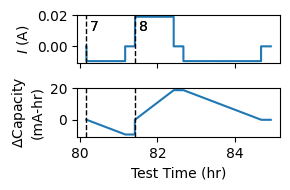

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2), sharex=True)

d = xcel_data.raw_data.query('cycle_number > 6')
ax = axs[0]
ax.plot(d['test_time'] / 3600, d['current'])
ax.set_ylabel('$I$ (A)')

ax = axs[1]
# Plot the cycle capacity
ax.plot(d['test_time'] / 3600, d['cycled_charge'] * 1000)

# Mark where cycles start
cycle_start = d.drop_duplicates('cycle_number', keep='first')[['test_time', 'cycle_number']]
for ax in axs:
    ax.set_ylim(ax.get_ylim())
    for ind, start in zip(cycle_start['cycle_number'], cycle_start['test_time']):
        axs[0].text(start / 3600 + 0.1, 0.01, ind)
        ax.plot([start / 3600] * 2, ax.get_ylim(), 'k--', lw=1)

ax.set_ylabel('$\Delta$Capacity\n(mA-hr)')
ax.set_xlabel('Test Time (hr)')

fig.tight_layout()

The battery was determined to have a capacity of ~19 mAh, consistent with what we see in the above plot for the second cycle (Cycle 8) but not the first. As discussed above, no all cycles are good for estimating capacity but we can do it.

Note how we get values close to the known capacity for some only a few of the cycles included in our dataframe.

In [18]:
capc.compute_features(xcel_data)

/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/battery-data-toolkit/battdat/postprocess/integral.py:104: UserWarning: Unable to clearly detect if battery started charged or discharged in cycle 6. Amount discharged is -0.00e+00 A-s, charged is 0.00e+00 A-s
  warnings.warn(f'Unable to clearly detect if battery started charged or discharged in cycle {cyc}. '


,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge,max_cycled_capacity
0,0,0.002256,0.000717,0.002256,0.000717,0.000717
1,1,0.080789,0.021868,0.080789,0.021868,0.021868
2,2,0.037928,0.010596,0.037928,0.010596,0.010596
3,3,0.045825,0.011212,0.045825,0.011212,0.019637
4,4,0.129641,0.036539,0.129641,0.036539,0.036539
5,5,0.028810,0.007866,0.028810,0.007866,0.008877
6,6,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.033207,0.009474,0.033207,0.009474,0.009474
8,8,0.070728,0.018946,0.069243,0.019008,0.019008
